In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 64

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = True

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 25,557,032
Trainable parameters: 25,557,032
Frozen parameters: 0


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [7]:
NUM_EPOCHS = 30
MODEL_NAME = 'resnet50_ft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 156.53s - 
Train Loss: 3.4082, Train Accuracy: 0.2913, Took 144.96s, 
Val Loss: 2.9379, Val Accuracy: 0.3508, Took 11.57s 



Epoch 2/30 Time: 152.59s - 
Train Loss: 2.5423, Train Accuracy: 0.4158, Took 141.08s, 
Val Loss: 2.6911, Val Accuracy: 0.3948, Took 11.52s 



Epoch 3/30 Time: 151.64s - 
Train Loss: 2.1546, Train Accuracy: 0.4883, Took 140.23s, 
Val Loss: 2.7281, Val Accuracy: 0.3935, Took 11.40s 



Epoch 4/30 Time: 150.85s - 
Train Loss: 1.8764, Train Accuracy: 0.5446, Took 139.45s, 
Val Loss: 2.8238, Val Accuracy: 0.3798, Took 11.40s 



Epoch 5/30 Time: 150.53s - 
Train Loss: 1.6187, Train Accuracy: 0.6025, Took 139.09s, 
Val Loss: 2.5513, Val Accuracy: 0.4318, Took 11.43s 



Epoch 6/30 Time: 148.65s - 
Train Loss: 1.2510, Train Accuracy: 0.6987, Took 138.08s, 
Val Loss: 2.4445, Val Accuracy: 0.4454, Took 10.58s 



Epoch 7/30 Time: 138.88s - 
Train Loss: 1.1081, Train Accuracy: 0.7375, Took 128.32s, 
Val Loss: 2.4484, Val Accuracy: 0.4411, Took 10.56s 



Epoch 8/30 Time: 139.69s - 
Train Loss: 0.9911, Train Accuracy: 0.7662, Took 129.11s, 
Val Loss: 2.4966, Val Accuracy: 0.4365, Took 10.59s 



Epoch 9/30 Time: 138.70s - 
Train Loss: 0.8914, Train Accuracy: 0.7943, Took 128.11s, 
Val Loss: 2.5099, Val Accuracy: 0.4356, Took 10.58s 



Epoch 10/30 Time: 140.10s - 
Train Loss: 0.7225, Train Accuracy: 0.8456, Took 129.52s, 
Val Loss: 2.4386, Val Accuracy: 0.4471, Took 10.58s 



Epoch 11/30 Time: 139.36s - 
Train Loss: 0.6621, Train Accuracy: 0.8633, Took 128.78s, 
Val Loss: 2.4511, Val Accuracy: 0.4460, Took 10.58s 



Epoch 12/30 Time: 139.43s - 
Train Loss: 0.6095, Train Accuracy: 0.8789, Took 128.86s, 
Val Loss: 2.4627, Val Accuracy: 0.4489, Took 10.57s 



Epoch 13/30 Time: 139.37s - 
Train Loss: 0.5646, Train Accuracy: 0.8899, Took 128.79s, 
Val Loss: 2.5012, Val Accuracy: 0.4452, Took 10.58s 



Epoch 14/30 Time: 139.46s - 
Train Loss: 0.4880, Train Accuracy: 0.9144, Took 128.88s, 
Val Loss: 2.4634, Val Accuracy: 0.4509, Took 10.58s 



Epoch 15/30 Time: 139.59s - 
Train Loss: 0.4616, Train Accuracy: 0.9209, Took 129.04s, 
Val Loss: 2.4579, Val Accuracy: 0.4524, Took 10.55s 



Epoch 16/30 Time: 139.77s - 
Train Loss: 0.4454, Train Accuracy: 0.9242, Took 129.20s, 
Val Loss: 2.4794, Val Accuracy: 0.4485, Took 10.56s 



Epoch 17/30 Time: 139.08s - 
Train Loss: 0.4232, Train Accuracy: 0.9309, Took 128.48s, 
Val Loss: 2.4890, Val Accuracy: 0.4501, Took 10.60s 



Epoch 18/30 Time: 139.15s - 
Train Loss: 0.3886, Train Accuracy: 0.9418, Took 128.57s, 
Val Loss: 2.4777, Val Accuracy: 0.4492, Took 10.58s 



Epoch 19/30 Time: 140.62s - 
Train Loss: 0.3790, Train Accuracy: 0.9435, Took 130.04s, 
Val Loss: 2.4893, Val Accuracy: 0.4479, Took 10.58s 



Epoch 20/30 Time: 139.92s - 
Train Loss: 0.3656, Train Accuracy: 0.9464, Took 129.31s, 
Val Loss: 2.4919, Val Accuracy: 0.4504, Took 10.61s 



Epoch 21/30 Time: 138.69s - 
Train Loss: 0.3599, Train Accuracy: 0.9477, Took 128.13s, 
Val Loss: 2.4931, Val Accuracy: 0.4475, Took 10.55s 



Epoch 22/30 Time: 139.38s - 
Train Loss: 0.3427, Train Accuracy: 0.9531, Took 128.80s, 
Val Loss: 2.4917, Val Accuracy: 0.4489, Took 10.58s 



Epoch 23/30 Time: 139.24s - 
Train Loss: 0.3382, Train Accuracy: 0.9547, Took 128.59s, 
Val Loss: 2.4949, Val Accuracy: 0.4485, Took 10.64s 



Epoch 24/30 Time: 139.34s - 
Train Loss: 0.3315, Train Accuracy: 0.9565, Took 128.75s, 
Val Loss: 2.4978, Val Accuracy: 0.4482, Took 10.59s 



Epoch 25/30 Time: 139.42s - 
Train Loss: 0.3258, Train Accuracy: 0.9569, Took 128.85s, 
Val Loss: 2.4996, Val Accuracy: 0.4469, Took 10.57s 



Epoch 26/30 Time: 139.37s - 
Train Loss: 0.3196, Train Accuracy: 0.9577, Took 128.79s, 
Val Loss: 2.5055, Val Accuracy: 0.4493, Took 10.58s 



Epoch 27/30 Time: 138.96s - 
Train Loss: 0.3150, Train Accuracy: 0.9585, Took 128.36s, 
Val Loss: 2.5053, Val Accuracy: 0.4495, Took 10.60s 



Epoch 28/30 Time: 150.45s - 
Train Loss: 0.3131, Train Accuracy: 0.9610, Took 138.92s, 
Val Loss: 2.5049, Val Accuracy: 0.4501, Took 11.52s 



Epoch 29/30 Time: 151.03s - 
Train Loss: 0.3118, Train Accuracy: 0.9618, Took 139.66s, 
Val Loss: 2.4955, Val Accuracy: 0.4484, Took 11.36s 



Epoch 30/30 Time: 151.36s - 
Train Loss: 0.3078, Train Accuracy: 0.9619, Took 139.95s, 
Val Loss: 2.5016, Val Accuracy: 0.4499, Took 11.41s 

Training Complete!


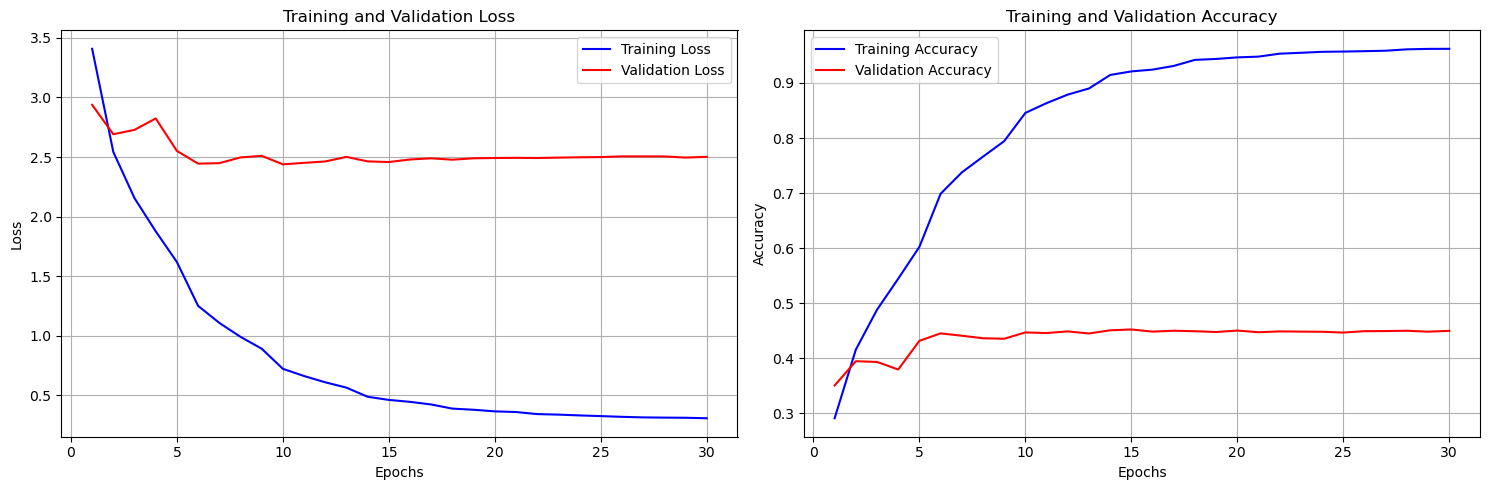

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from resnet50_ft.pth


Best model - Validation Loss: 2.5023, Validation Accuracy: 0.4494


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.4495, Top-5 Accuracy: 0.7190
